# EOF Analysis of AR days

* Multivariate EOF analysis - testing different configurations to see which cEOF captures the most varaince of precipitation related to AR events

  1. cEOF 250 hPa H, U, V in extratropics, 850 hPa Q, U, V in tropics
  2. cEOF 500 hPa H, U, V in extratropics, 500 hPa Q, U, V in tropics
  3. cEOF 500 hPa H, U, V in extratropics, 500 hPa H, U, V in tropics
  4. cEOF 500 hPa H, U, V in full domain [0-120E, 0-50N]
  5. cEOF IVTu and IVTv in full domain
  6. cEOF 500 hPa H, U, V and 850 hPa Q in full domain
  7. cEOF 500 hPa H, U, V in extended domain [20-120E, 0-50N]
  8. cEOF 500 hPa H, U, V in full domain, with 10% AR threshold
  9. cEOF 250 hPa H, U, V in full domain


In [1]:
# Import Python modules
import os, sys
import yaml
from pathlib import Path
import numpy as np
import numpy.ma as ma
import pandas as  pd
import xarray as xr
from sklearn.cluster import KMeans
from itertools import cycle
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import ListedColormap
from matplotlib import rcParams
import matplotlib.ticker as mticker
# cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cartopy.feature as cfeature
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean

from IPython.display import Image, display
from scipy import stats

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap
from timeseries import persistence, select_months
from eofs import *
from ar_funcs import get_ar_days
from kmeans import *
from utils import check_mkdir

In [2]:
# Set up paths

path_to_data = '/home/nash/DATA/data/'                            # project data -- read only
path_to_out  = '/home/nash/DATA/repositories/AR_types/out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '/home/nash/DATA/repositories/AR_types/figs/'      # figures


In [3]:
# Set a default font for all matplotlib text (can only set this ONCE; must restart kernel to change it)

rcParams['font.family'] = 'sans-serif'   # set the default font family to 'sans-serif'
rcParams['font.sans-serif'] = 'Arial'    # set the default sans-serif font to 'Arial'

### Configuration Dictionary

In [4]:
## Select MERRA2 or ERA5
reanalysis = 'era5'

# import configuration file for season dictionary choice
yaml_doc = '../data/config.yml'
config1 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ssn = 'mam'
ar_dict = config1[ssn]

# import configuration file for ceof dictionary choice
## test number - NOTE as of 7/1/2020 sticking with test 4
yaml_doc = '../data/ceof_config.yml'
config2 = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
config_dict = config2['test5']

start_date = ar_dict['start_date']
end_date = ar_dict['end_date']
print(start_date, end_date)


1979-03-01 9:00 2019-5-31 9:00


## Data

### AR time series

In [5]:
# if using single bound box
bound_box = [20, 40, 65, 95]
trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=False, bbox=bound_box, thresh=None)
df
# # if using 3 subregions and threshold
# trackIDs, df = get_ar_days(reanalysis, start_date, end_date, subregions=True, bbox=None, thresh=0.3)


,ar
time,
1979-03-01 09:00:00,0.0
1979-03-02 09:00:00,0.0
1979-03-03 09:00:00,0.0
1979-03-04 09:00:00,1.0
1979-03-05 09:00:00,1.0
...,...
2019-05-27 09:00:00,0.0
2019-05-28 09:00:00,0.0
2019-05-29 09:00:00,0.0


### Import reanalysis

#### ERA5

In [6]:
## Set variable names (for saving data/figs)
testname = config_dict['name']
eofmode = 't' # s or t
dispmat = 'cor' # dispersion matrix type correlation/covariance
pathvar = config_dict['pathvar']
ceofid = config_dict['fnameID']

# Select lat/lon grid 
# Tropics/Extratropics Domain
lonmin = config_dict['latlon'][0]
lonmax = config_dict['latlon'][1]
latmin = config_dict['latlon'][2]
latmax = config_dict['latlon'][3]

lev = config_dict['levs']

out_path = path_to_out + ceofid + '/' + ssn + '/'
fig_path = path_to_figs + ceofid + '/' + ssn + '/'
# make directories if paths do not exist
check_mkdir(out_path)
check_mkdir(fig_path)

if pathvar == 'huvq':
    def preprocess(ds):
        '''keep only selected lats and lons'''
        return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax), level=lev)
if pathvar == 'ivt':
        def preprocess(ds):
            '''keep only selected lats and lons'''
            return ds.sel(latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))

# open anomaly data
filepath_pattern = path_to_data + 'ERA5/{0}/anomalies/daily_filtered_anomalies_{0}_*.nc'.format(pathvar)
    
    
f2 = xr.open_mfdataset(filepath_pattern, preprocess=preprocess, combine='by_coords')

f2

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 241, time: 14975)
Coordinates:
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 118.5 119.0 119.5 120.0
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 48.0 ... 1.5 1.0 0.5 0.0
  * time       (time) datetime64[ns] 1979-01-01T09:00:00 ... 2019-12-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(365,), meta=np.ndarray>
Data variables:
    p72.162    (time, latitude, longitude) float64 dask.array<chunksize=(365, 101, 241), meta=np.ndarray>
    p71.162    (time, latitude, longitude) float64 dask.array<chunksize=(365, 101, 241), meta=np.ndarray>

In [7]:
# rename vars and coords to streamline code
if pathvar == 'huvq':
    rename_dict = {'z': 'H', 
                   'u': 'U', 
                   'v':'V', 
                   'q': 'QV',
                   'latitude': 'lat',
                   'longitude': 'lon'}
    ds = f2.rename(rename_dict)

if pathvar == 'ivt':
    rename_dict = {'p71.162': 'ivte', 
                   'p72.162': 'ivtn', 
                   'latitude': 'lat',
                   'longitude': 'lon'}
    ds = f2.rename(rename_dict)
    
print('ds size in GB {:0.2f}\n'.format(ds.nbytes / 1e9))

ds size in GB 5.83



In [8]:
# slice to match ar catalog end date
idx = slice(start_date, end_date)
ds = ds.sel(time=idx)

# Add AR time series to merra; set as coordinate variables
ds['ar'] = ('time', df.ar)
ds = ds.set_coords('ar')

# print dataset
print(ds)

<xarray.Dataset>
Dimensions:    (lat: 101, lon: 241, time: 14702)
Coordinates:
  * lon        (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
  * lat        (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * time       (time) datetime64[ns] 1979-03-01T09:00:00 ... 2019-05-31T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(306,), meta=np.ndarray>
    ar         (time) float64 0.0 0.0 0.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Data variables:
    ivtn       (time, lat, lon) float64 dask.array<chunksize=(306, 101, 241), meta=np.ndarray>
    ivte       (time, lat, lon) float64 dask.array<chunksize=(306, 101, 241), meta=np.ndarray>


### Data Subset Selection

In [9]:
# Select months
if ar_dict['mon_s'] > ar_dict['mon_e']:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) | (ds.time.dt.month <= ar_dict['mon_e'])
else:
    idx = (ds.time.dt.month >= ar_dict['mon_s']) & (ds.time.dt.month <= ar_dict['mon_e'])

ds = ds.sel(time=idx)

# # Select AR days JUST IN R01
# idx = (ds.ar >= 1) & (ds.location == 'R01')
# Select AR days in all subregions
idx = (ds.ar >= 1)
ds_ar = ds.sel(time=idx)
# ds_ar = ds

# print results
print(ds_ar)

<xarray.Dataset>
Dimensions:    (lat: 101, lon: 241, time: 2031)
Coordinates:
  * lon        (lon) float32 0.0 0.5 1.0 1.5 2.0 ... 118.5 119.0 119.5 120.0
  * lat        (lat) float32 50.0 49.5 49.0 48.5 48.0 ... 2.0 1.5 1.0 0.5 0.0
  * time       (time) datetime64[ns] 1979-03-04T09:00:00 ... 2019-05-25T09:00:00
    dayofyear  (time) int64 dask.array<chunksize=(51,), meta=np.ndarray>
    ar         (time) float64 1.0 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
Data variables:
    ivtn       (time, lat, lon) float64 dask.array<chunksize=(51, 101, 241), meta=np.ndarray>
    ivte       (time, lat, lon) float64 dask.array<chunksize=(51, 101, 241), meta=np.ndarray>


In [10]:
# Count number of independent AR events and their duration in days
x = ds.ar
event_id, total_events, duration = persistence(x)
print('Total number of AR days in season: ', x.sum())
print('Total number of independent AR events: ', total_events)

Total number of AR days in season:  <xarray.DataArray 'ar' ()>
array(2031.)
Total number of independent AR events:  601


## Preprocessing

### Reshape, center, and standardize data matrix

In [11]:
%%time
# Load dataset into memory
ds_ar = ds_ar.load()


CPU times: user 2.28 s, sys: 14.2 s, total: 16.5 s
Wall time: 13.5 s


In [12]:
## Create list of variable arrays
    
var_list = []
for i in range(len(config_dict['varlist'])):
    var1 = config_dict['varlist'][i]
    domain = config_dict['domain'][i]
    domain_bnds = config2['eof_domain'][domain]
    lonslice = slice(domain_bnds[0], domain_bnds[1])
    latslice = slice(domain_bnds[3], domain_bnds[2])
    if pathvar == 'huvq':
        lev = config_dict['varlev'][i]
        var_list.append(ds_ar[var1].sel(lon=lonslice, lat=latslice, level=lev))
    if pathvar == 'ivt':
        var_list.append(ds_ar[var1].sel(lon=lonslice, lat=latslice))

# Check that sizes of arrays match
for i, in_array in enumerate(var_list):
    # Extract variable as numpy array
    var1 = in_array.values
    print(var1.shape)


(2031, 101, 241)
(2031, 101, 241)


In [13]:
%%time
# Weight the data by the square root of the cosine of the lat
var_list = spatial_weights(var_list)

## Flatten data to [time x space]
var_list = flatten_array(var_list)

## Center data
var_list = center_data(var_list)

## Standardize Arrays by removing the mean and dividing by the standard deviation of the columns
## For multivariate, place into single flattened array
Xs = standardize_arrays(var_list, mode=eofmode, dispersion_matrix=dispmat)


EOF mode:  t
Dispersion Matrix:  cor
(48682, 2031)
Column means:  0.0
Column std:  1.0
CPU times: user 8.37 s, sys: 4.6 s, total: 13 s
Wall time: 12.9 s


## EOF Analysis

In [14]:
%%time

# Compute eigenvalues & eigenvectors
R, evals, evecs = calc_eigs(z=Xs, mode=eofmode)

print('Eigenvalues: ', evals.shape)
print(evals, '\n')

print('Eigenvectors: ', evecs.shape)
print(np.round(evecs, 3), '\n')

# save eigenvalues and eigenvectors
outfile = out_path + 'eigenvalues_' + eofmode + dispmat + '.txt'
np.savetxt(outfile, evals, fmt='%.5f')

outfile = out_path + 'eigenvectors_' + eofmode + dispmat + '.txt'
np.savetxt(outfile, evecs, fmt='%.5f', delimiter=',')

Eigenvalues:  (2031,)
[1.65406217e+02 1.37412806e+02 1.05365484e+02 ... 6.01468000e-03
 6.02788035e-03 6.01762226e-03] 

Eigenvectors:  (2031, 2031)
[[-0.013 -0.006  0.016 ...  0.021  0.008  0.015]
 [-0.01  -0.006 -0.009 ...  0.013  0.038 -0.037]
 [-0.001  0.013 -0.017 ...  0.005  0.02   0.002]
 ...
 [-0.021  0.002 -0.046 ... -0.012 -0.023 -0.033]
 [-0.019  0.014 -0.03  ...  0.02   0.     0.023]
 [-0.011  0.03  -0.015 ...  0.019  0.045 -0.023]] 

CPU times: user 6min 47s, sys: 8min 10s, total: 14min 57s
Wall time: 23.2 s


### Explained Variance

In [15]:
# Calculate the percent explained var by each eigenvector
pctvar = pct_variance(evals)

# Number of EOFs that explain more than 1% of the total variance
idx = pctvar[pctvar >= 1.0]
neofs = len(idx)

# print exp var >= 1.0
cumvar = np.sum(pctvar[0:neofs-1])
print(f'Cumulative variance explained by the first {neofs} EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var: neofs = 4
cumvar = np.sum(pctvar[0:3])
print(f'Cumulative variance explained by the first 4 EOFs:')
print(f'{cumvar:.2f}% \n')

# print exp var for 4 eofs
for k in range(4):
    print(f'{k+1} \t {pctvar[k]:.2f}%')

Cumulative variance explained by the first 23 EOFs:
59.73% 

Cumulative variance explained by the first 4 EOFs:
20.10% 

1 	 8.14%
2 	 6.77%
3 	 5.19%
4 	 4.17%


### North Test

In [16]:
err = north_test(evals, total_events)
upper = pctvar + err
lower = pctvar - err

print(np.round(upper[0:6],3))
print(np.round(pctvar[0:6],3))
print(np.round(lower[0:6],3))

[8.614 7.156 5.487 4.407 3.936 3.58 ]
[8.144 6.766 5.188 4.166 3.721 3.384]
[7.674 6.375 4.888 3.926 3.507 3.189]


In [17]:
# get the number of EOFs that are separated based on the North Test
n = []
i = 0
while lower[i] > upper[i+1]:
    n.append(i+1)
    i += 1
print('Number of separated EOFs: ', max(n))

Number of separated EOFs:  3


### EOFs and PCs

In [18]:
# choose neofs and npcs based on North Test - where separated
# to save, plot, etc.
neofs = max(n)
npcs = neofs

# Calculate EOFS (spatial modes)
eofs = calc_eofs(Xs, evecs, evals, neofs, mode=eofmode)

# Split eofs into separate arrays for each variable
ntim, nlat, nlon = var1.shape
npts = nlat*nlon
nvar = len(var_list)
# Reshape spatial dim back to 2D map
eofmodes = var_list
for i in np.arange(len(var_list)):
    tmp = eofs[:,i*npts:(i+1)*npts]
    eofmodes[i] = np.reshape(tmp, (neofs,nlat,nlon))
    
# Calculate PCs (time coefficients)
pcs = calc_pcs(Xs, evecs, evals, npcs, mode=eofmode)
# results in [ntim, npcs] to plot in PC plot

## loadings*
## in the case of t-mode these are our "pcs" or time-coefficients
## in the case of s-mode, these are our "eofs" or spatial loadings
loads = pcs



### Spatial Modes

In [19]:
# Data for plotting 
lons = ds_ar.lon.data
lats = ds_ar.lat.data
if ceofid == 'IVT':
    udat = eofmodes[0][0:neofs,:,:]
    vdat = eofmodes[1][0:neofs,:,:]
    data = np.sqrt(udat**2 + vdat**2)
    
    cflevs = np.arange(25, 225, 25)
    cmap=cmo.deep
    extend = 'max'
    cb_lbl = 'kg m$^{-1}$ s$^{-1}$'

else:
    udat = eofmodes[1][0:neofs,:,:]
    vdat = eofmodes[2][0:neofs,:,:]
    data = eofmodes[0][0:neofs,:,:]
    
    cflevs = cflevs = np.arange(-30,31,5)
    cmap="bwr"
    extend = 'both'
    cb_lbl = 'm'
    
print(np.nanmin(data), np.nanmax(data))

# Set up projection
mapcrs = ccrs.PlateCarree()
datacrs = ccrs.PlateCarree()

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+20,20)
dy = np.arange(latmin,latmax+20,20)

# subtitles
eof_label = [ ]
pc_label = [ ]
var_label = [ ]
for k in range(neofs):
    eof_label.append("cEOF{:1d}".format(k+1,))
    pc_label.append("PC{:1d}".format(k+1,))
    var_label.append("{:.2f}%".format(pctvar[k]))

0.027066937190933688 90.1004513633203


In [20]:
# make a dict of the first n eofs with column labels for df
values = []
for i in range(neofs):
    values.append(loads[:,i])
    
keys = eof_label
dicts = dict(zip(keys, values))
# print(dicts)

# Create new dataframe
dates_arDays = ds_ar.time.values
df_out = pd.DataFrame(dicts, index=dates_arDays)

# Save loadings
outfile = out_path + 'loadings_' + eofmode + dispmat + '.csv'
# np.savetxt(outfile, loads[:,0:neofs], fmt='%.4f', delimiter=',')
df_out.to_csv(outfile)

In [21]:
# load filtered daily mean 250 hPa winds
# plot mean position of subtropical jet (>40 m s-1)
# filename = path_to_data + 'ERA5/huvq/filtered_daily_mean_clim_huvq.nc'
filename = path_to_data + 'ERA5/huvq/daily_mean_clim_huvq.nc'
ds = xr.open_dataset(filename)
idx = (ds.dayofyear >= 336) | (ds.dayofyear <= 152)
ds = ds.sel(dayofyear=idx, level=250., latitude=slice(latmax, latmin), longitude=slice(lonmin, lonmax))
ds = ds.assign(wspd=lambda ds: np.sqrt(ds.u**2 + ds.v**2))
ds_mean = ds.mean('dayofyear')
ds_mean

<xarray.Dataset>
Dimensions:    (latitude: 101, longitude: 241)
Coordinates:
  * latitude   (latitude) float32 50.0 49.5 49.0 48.5 48.0 ... 1.5 1.0 0.5 0.0
  * longitude  (longitude) float32 0.0 0.5 1.0 1.5 ... 118.5 119.0 119.5 120.0
    level      float64 250.0
Data variables:
    z          (latitude, longitude) float32 100530.47 100516.27 ... 107494.71
    q          (latitude, longitude) float32 2.4033237e-05 ... 0.00022649238
    u          (latitude, longitude) float32 13.258855 13.136548 ... -7.5317054
    v          (latitude, longitude) float32 -5.237847 -5.2759557 ... 1.3712342
    wspd       (latitude, longitude) float32 14.854264 14.77737 ... 7.745985

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


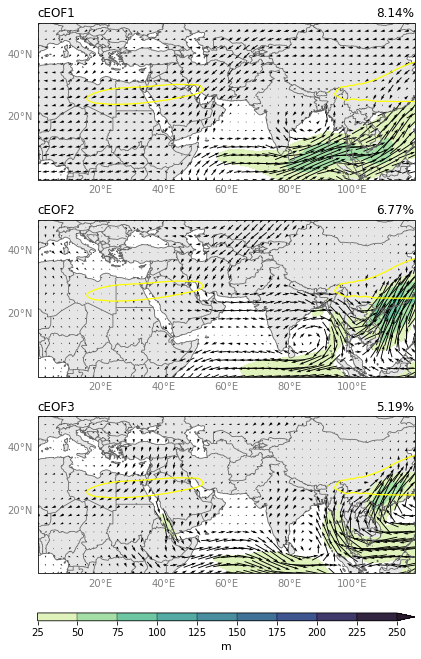

In [22]:
# Create figure
fig = plt.figure(figsize=(10,11))
filepath = fig_path + 'spatial_' + eofmode + dispmat + '.png'
nrows = neofs
ncols = 1

# Set up Axes Grid
axes_class = (GeoAxes,dict(map_projection=mapcrs))
axgr = AxesGrid(fig, 
                111, 
                axes_class=axes_class,
                nrows_ncols=(nrows, ncols), 
                axes_pad = 0.55,
                cbar_location='bottom', 
                cbar_mode='single',
                cbar_pad=0.0, 
                cbar_size='5%',
                label_mode='')

# Loop for drawing each plot
for k, ax in enumerate(axgr):
    ax = draw_basemap(ax, extent=[lonmin,lonmax,latmin,latmax], xticks=dx, yticks=dy)
    
    # Contour Filled
    cf = ax.contourf(lons, lats, data[k,:,:], transform=datacrs,
                     levels=cflevs, cmap=cmap, extend=extend)
    
    # Contours (average upper-level jet position)
    clevs = np.array([40])
    cs = ax.contour(lons, lats, ds_mean.wspd, transform=datacrs,
                     levels=clevs, colors='yellow', linewidths=1.25)
    
    
    # Wind barbs / vectors
    ax.quiver(lons, lats, udat[k,:,:], vdat[k,:,:], transform=datacrs,
              color='black', pivot='middle', regrid_shape=20) 
    
    # subtitles
    ax.set_title(eof_label[k], loc='left', fontsize=12)
    ax.set_title(var_label[k], loc='right', fontsize=12)
    
# single colorbar
cb = fig.colorbar(cf, axgr.cbar_axes[0], orientation='horizontal', drawedges=True)
cb.set_label(cb_lbl, fontsize=11)
cb.ax.tick_params(labelsize=10)
    
# Display figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')
plt.show()

### K-means clustering

In [23]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

# FUNCTIONS

def plot_optimal_k(data, neofs, kmax, create_plot=False, filename=None):
    """ Elbow plot to determine optimal number of clusters (k) 
    
    Parameters
    ----------
    data : array_like
        data to perform clustering on where rows= obs and cols = variables
    kmax : scalar, int
        maximum number of clusters; iteration over the interval k=[1,kmax]
    filename : string (optional)
        filename or path to save figure. Default is None (fig not saved).
    """
    
    # Cohesion = sum of sq dist of samples to their cluster center
    kclusters = np.arange(1, kmax, dtype=int) + 1
    cohesion = np.empty((neofs, kmax-1))
    silhouette = np.empty((neofs, kmax-1))
    upper = np.empty((neofs, kmax-1))
    lower = np.empty((neofs, kmax-1))
    
    # iterate over EOFs
    for i in range(neofs):
        X = data[:,0:i+2]
        
        # iterate over kclusters
        for j in range(len(kclusters)):
            ki = kclusters[j]
            km = KMeans(n_clusters=kclusters[j])
            cluster_labels = km.fit_predict(X)
            km = km.fit(X)
            cohesion[i, j] = (km.inertia_)

            # The silhouette_score gives the average value for all the samples.
            # This gives a perspective into the density and separation of the formed
            # clusters
            silhouette[i, j] = silhouette_score(X, cluster_labels)
            # Compute the silhouette scores for each sample
            sample_silhouette_values = silhouette_samples(X, cluster_labels)
            
            spread = []
            for m in range(ki):
                # Aggregate the silhouette scores for samples belonging to
                # cluster i, and sort them
                ith_cluster_silhouette_values = \
                    sample_silhouette_values[cluster_labels == m]

                ith_cluster_silhouette_values.sort()
                spread.append(ith_cluster_silhouette_values.max())
            
            lower[i, j] = min(spread)
            upper[i, j] = max(spread)

            
    if create_plot == True:
        fig = plt.figure()
        fig.set_size_inches((6.0,10.0))
        fig.dpi = 300
        sns.set_style("whitegrid")
        colors = ['tab:blue', 'tab:red', 'tab:green', 'k', 'orange']
        
        # Elbow plot
        ax = plt.subplot(2, 1, 1)
        for k in range(neofs):
            coh = cohesion[k, :]
            ax.plot(kclusters, coh, c=colors[k], marker='o', linewidth=2.0, markersize=7.0)
#             ax.set_title('Elbow Plot for Optimal K')
            ax.set_ylabel('Sum of Sq Dist (cohesion)')
            ax.set_xlabel('k (# of clusters)')
            ax.set_xlim(1., kmax+1)
#             ax.set_ylim(0, 210)
            ax.set_xticks(kclusters)
        
        # Silhouette plot
        ax2 = plt.subplot(2, 1, 2)
        for k in range(neofs):
            sil = silhouette[k, :]
            ax2.plot(kclusters, sil, c=colors[k], marker='o', linewidth=2.0, markersize=7.0)
            ax2.fill_between(kclusters, lower[k, :], upper[k, :], fc=colors[k], ec=None, alpha=0.2)
            ax2.set_ylabel('Mean Silhouette')
            ax2.set_xlabel('k (# of clusters)')
            ax2.set_xlim(1., kmax+1)
            ax2.set_ylim(0, 1.)
            ax2.set_xticks(kclusters)
        
        if filename:
            # Save the figure
            fig.savefig(filename, bbox_inches='tight', dpi=fig.dpi)
            fig.clf()
    else:
        return kclusters, cohesion


/home/nash/DATA/repositories/AR_types/figs/IVT/mam/elbow_tcor.png


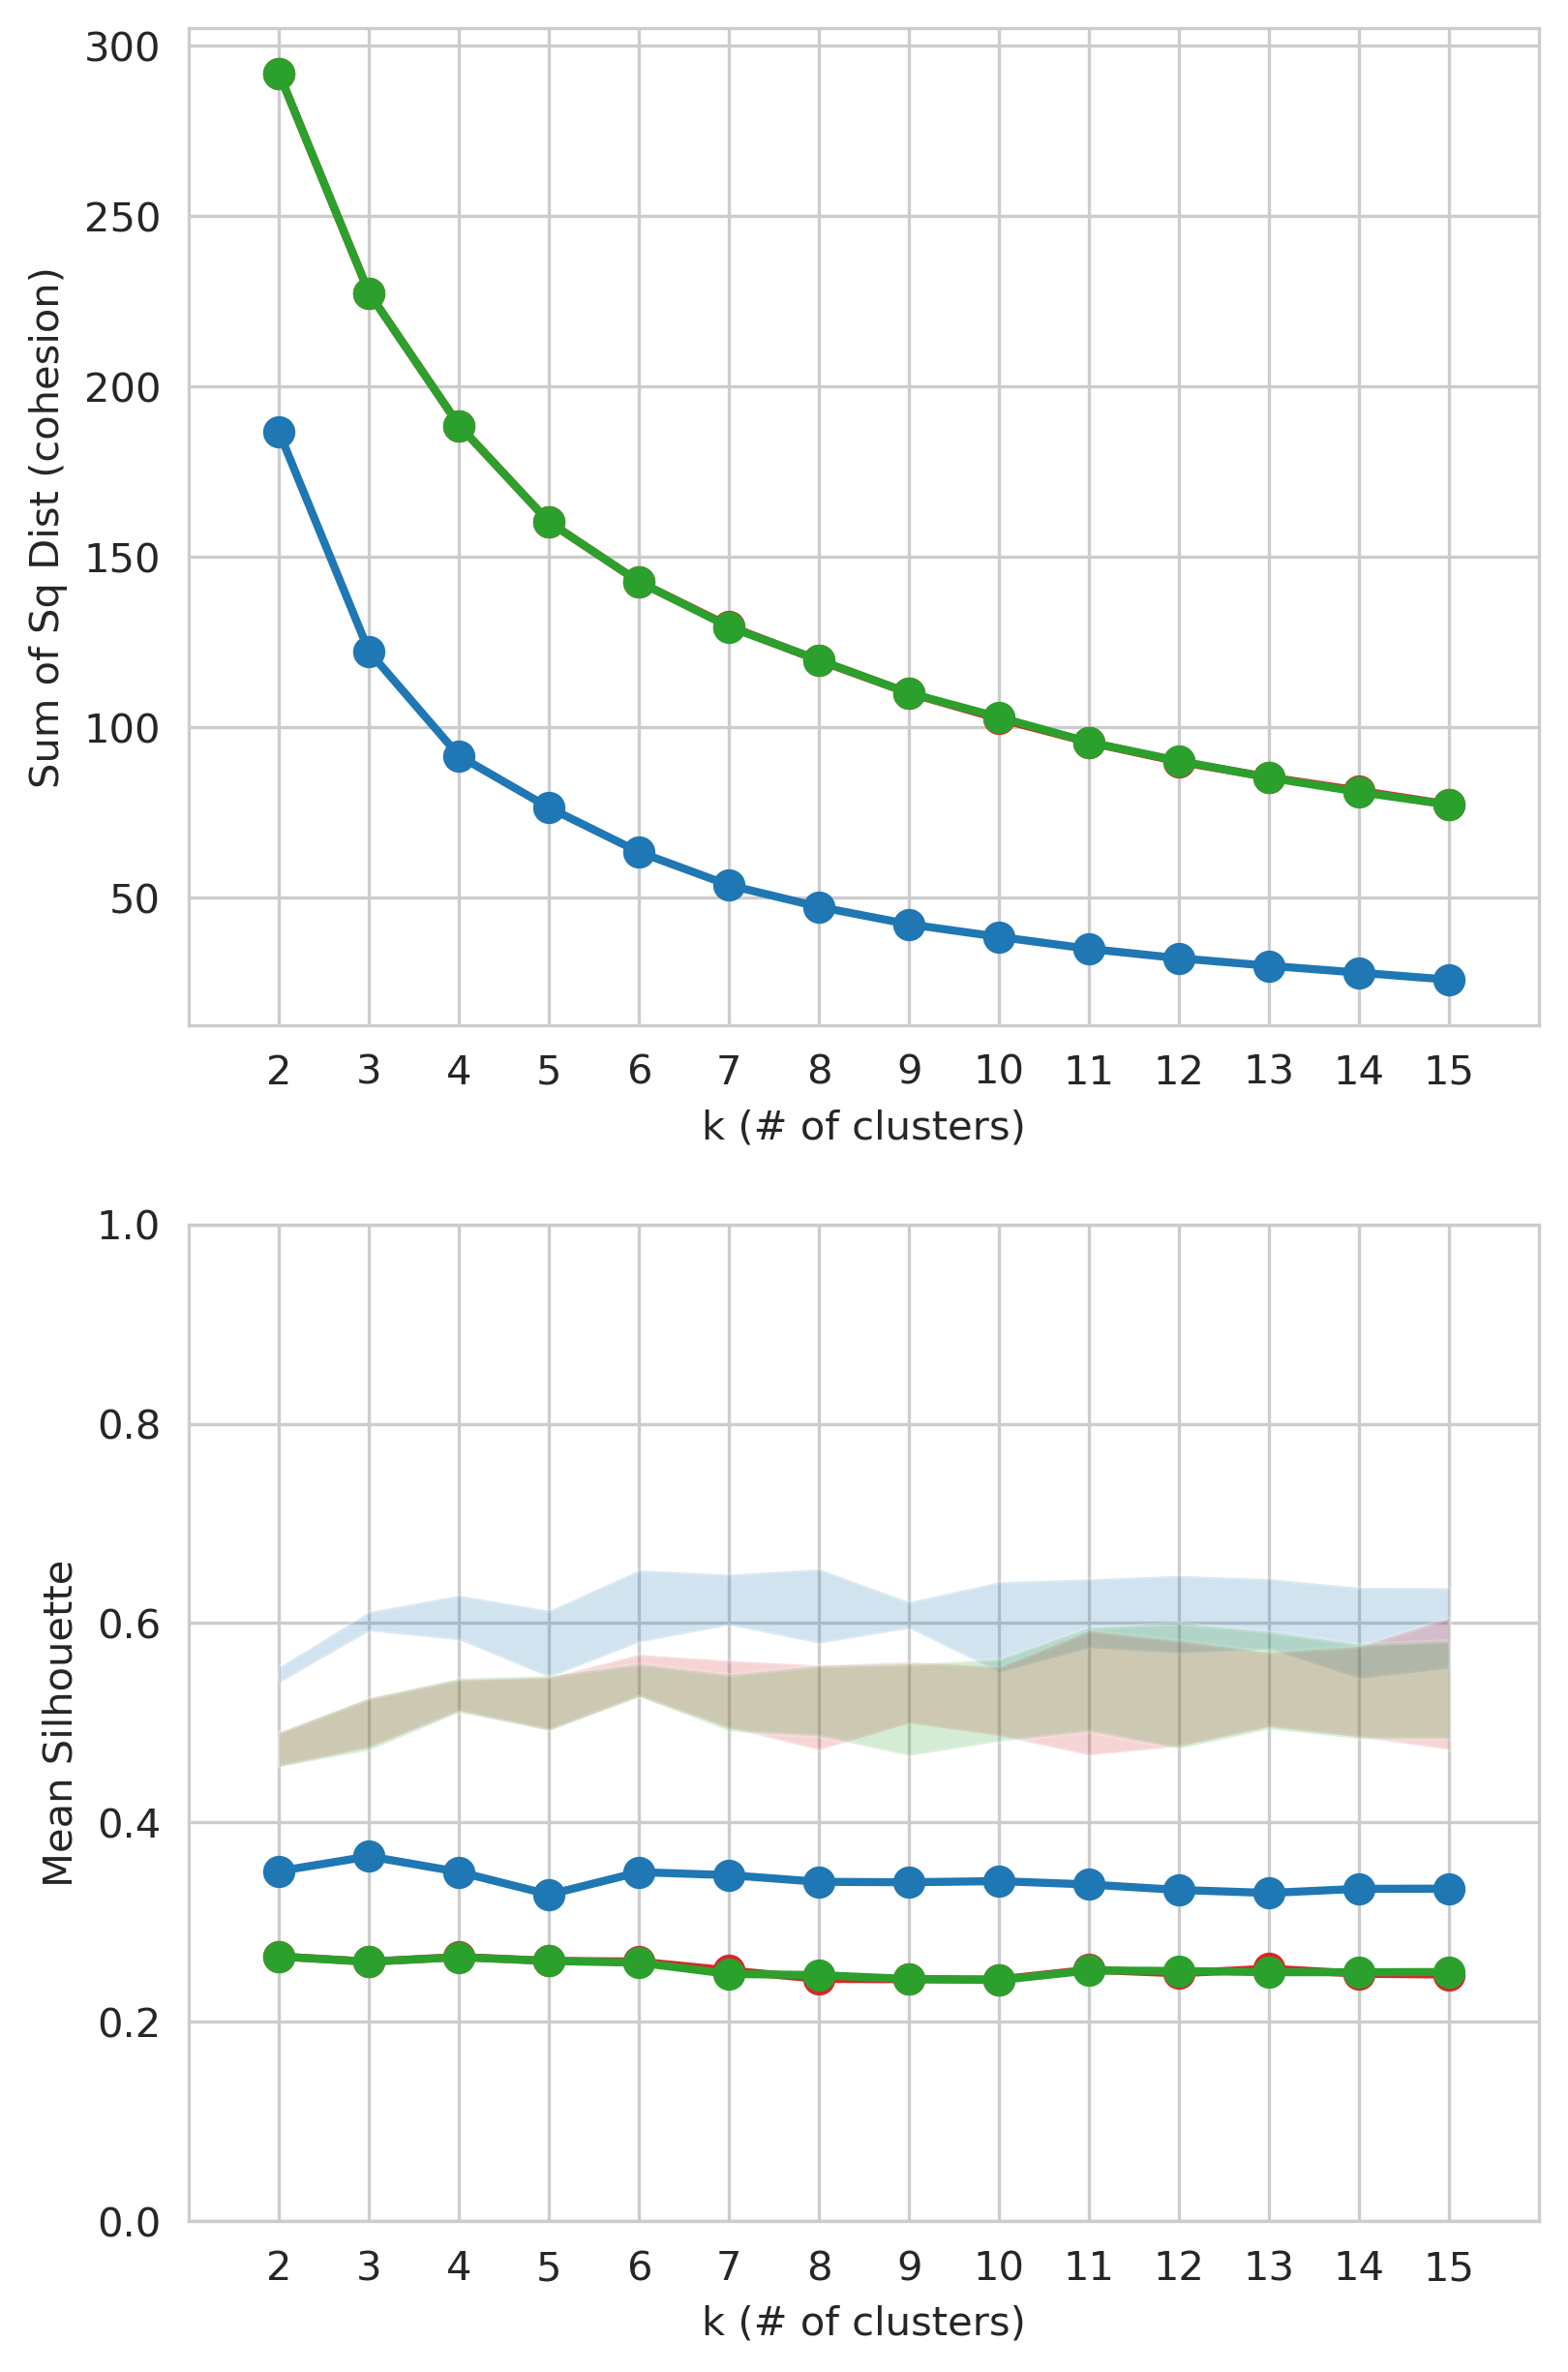

<Figure size 1800x3000 with 0 Axes>

In [24]:
# Determine optimal K
# maximum number of clusters (number of iterations)
kmax = 15

# Elbow plot
outfile = fig_path + 'elbow_' + eofmode + dispmat + '.png'
plot_optimal_k(loads, neofs, kmax, create_plot=True, filename=outfile)

print(outfile)
display(Image(outfile))

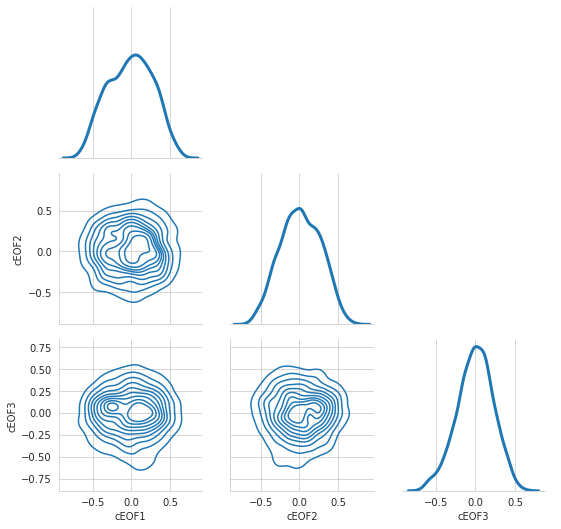

In [25]:
# determine optimal k by examining the kde of the eofs
g = sns.PairGrid(df_out, diag_sharey=True, corner=True)
# g.map_upper(sns.kdeplot)
g.map_lower(sns.kdeplot)
g.map_diag(sns.kdeplot, lw = 3)
g = g.add_legend(fontsize=14)

outfile = fig_path + 'hist_kde_' + eofmode + dispmat + '.png'
g.savefig(outfile)